In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [3]:
df.shape

(4026, 7)

In [4]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [6]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [7]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [8]:
y=normalized_df["Period (P)"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

# LightGBM

In [10]:
import lightgbm as lgb

In [11]:
from sklearn.model_selection import KFold,cross_validate
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplg

In [12]:
param_grid_simple={'n_estimators':hp.quniform('n_estimators',800,5000,50)
                   ,'max_depth':hp.quniform('max_depth',2,10,1)
                   ,'num_leaves':hp.quniform('num_leaves',10,50,1),
                   'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
                  }



In [13]:
def hyperopt_objective(params):
    model=lgb.LGBMRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,num_leaves=int(params['num_leaves'])
              ,learning_rate=params['learning_rate']
              ,random_state=99
              ,n_jobs=4)
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))

In [14]:
def param_hyperopt(max_evals=100):
    trials=Trials()
    early_stop_fn=no_progress_loss(100) 
    
    
    params_best=fmin(hyperopt_objective 
                     ,space=param_grid_simple 
                     ,algo=tpe.suggest 
                     ,max_evals=max_evals 
                     ,trials=trials 
                     ,early_stop_fn=early_stop_fn 
                    )
    
    print('best parmas:',params_best)
    return params_best,trials


In [15]:
def hyperopt_validation(params):
    model=lgb.LGBMRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,num_leaves=int(params['num_leaves'])
              ,learning_rate=params['learning_rate']
              ,random_state=99
              ,n_jobs=4)
        
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))


In [16]:
# Start time
start_time = time.time()

params_best, trials = param_hyperopt(100)

hyperopt_validation(params_best)

trials.trials[0]

trials.losses()[:10]
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

100%|██████████| 100/100 [34:31<00:00, 20.71s/trial, best loss: 0.0034346550099434645]
best parmas: {'learning_rate': 0.0975524873325442, 'max_depth': 6.0, 'n_estimators': 4850.0, 'num_leaves': 26.0}
Total time taken:  2100.312326669693


In [17]:
params_best['max_depth'] = int(params_best['max_depth'])
params_best['n_estimators'] = int(params_best['n_estimators'])
params_best['num_leaves'] = int(params_best['num_leaves'])
lgb_reg= lgb.LGBMRegressor(**params_best  )
lgb_reg.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 2415, number of used features: 6
[LightGBM] [Info] Start training from score 0.301664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.09755, max_depth=6, n_estimators=4850,
              num_leaves=26)

In [18]:
y_pred= lgb_reg.predict(X_test)
y_pred1=lgb_reg.predict(X_val)
y_pred2=lgb_reg.predict(X_train)

In [19]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.0016733623426824994
mean_squared_error: 1.6857390235651388e-05
rmse: 0.004105775229557919
r2 score: 0.9996709511638571


In [20]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.0016450661937709233
mean_squared_error: 7.674507028178048e-06
rmse: 0.002770290062101449
r2 score: 0.9998460752064426


In [21]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.000539722045372014
mean_squared_error: 1.594907636343186e-06
rmse: 0.0012628965263802043
r2 score: 0.9999673945004878


In [22]:
from yellowbrick.regressor import PredictionError

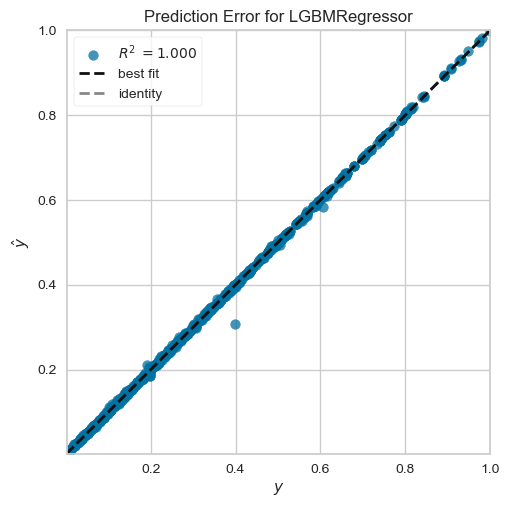

<Axes: title={'center': 'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [23]:
visualizer = PredictionError(lgb_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()